# **Complete Summary of all the Steps You Performed** in your rock/paper/scissors Classification Project with InceptionV3, from start to fine-tuning:

---

### **1️⃣ Dataset Preparation**

* Collected original images (\~350 images).
* Split into **training (70%)** and **Testing (15%)** and **validation (15%)** datasets.
* Organized into subfolders for each class: `rock`, `paper`, `scissors`.

---

### **2️⃣ Data Loading**

* Loaded datasets using `image_dataset_from_directory`.
* Resized images to **224×224** and set **batch size = 32**.
* Prefetched datasets for performance.

---

### **3️⃣ Data Augmentation**

* Defined a `tf.keras.Sequential` augmentation pipeline:

  * `RandomFlip('horizontal')`
  * `RandomRotation(0.2)`
  * `RandomZoom(0.2)`
* Augmentation applied **on-the-fly** during training (virtual increase in dataset size).

---

### **4️⃣ Model Loading & Building**

* Loaded **InceptionV3 base model** without top layers.
* Loaded custom weights (`inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5`).
* Added **custom classification layers**:

  * `GlobalAveragePooling2D()`
  * `Dropout(0.5)`
  * `Dense(3, activation='softmax')`

---

### **5️⃣ Model Compilation**

* Compiled with:

  * Optimizer: `Adam(lr=0.0001)`
  * Loss: `sparse_categorical_crossentropy`
  * Metric: `accuracy`

---

### **6️⃣ Callbacks Setup**

* `EarlyStopping` → stops if `val_loss` doesn’t improve for 5 epochs.
* `ModelCheckpoint` → saves the **best model** based on `val_accuracy`.
* `StopAtAccuracy` → custom callback to stop training if validation accuracy reaches 95%.

---

### **7️⃣ Model Training**

* Trained on **train\_dataset**, validated on **val\_dataset**.
* Maximum epochs: 20.
* Callbacks used to save best model and stop training early.
* Stored **history object** for metrics.

---

### **8️⃣ Visualizing Training Results**

* Plotted **accuracy and loss** over epochs for both **training** and **validation** datasets.
* Printed **final accuracy and loss** after training.
* Optionally printed **epoch-wise metrics**.
* Converted history to **pandas DataFrame** for tabular view.

---

### **9️⃣ Fine-Tuning**

* Unfroze last 50 layers of InceptionV3 for training.
* Recompiled with **smaller learning rate (1e-5)**.
* Continued training with same callbacks.
* Stored **history\_finetune** for metrics after fine-tuning.

---

### **🔟 Visualizing Fine-Tuning Results**

* Plotted **accuracy and loss graphs** for fine-tuning.
* Printed **final metrics** after fine-tuning.
* Converted `history_finetune` to **DataFrame** for analysis.

---

### **Optional Step**

* Saved fine-tuned model using `ModelCheckpoint` or `model.save('fine_tuned_model.keras')`.
* Ready for **inference or deployment**.

---



# Import Libraries

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import os
import shutil
import random


# Set the Dataset 

In [2]:
# Paths
original_dataset_dir = r'F:\Project_Image\rps-test-set'
base_dir = r'F:\Project_Image\rps_dataset'

# Create directories
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')  # new test folder

for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

classes = ['rock', 'paper', 'scissors']

# Create subfolders for each class
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratios
train_ratio = 0.7   # 70% for training
val_ratio = 0.15    # 15% for validation
test_ratio = 0.15   # 15% for testing

# Move files
for cls in classes:
    cls_path = os.path.join(original_dataset_dir, cls)
    files = os.listdir(cls_path)
    random.shuffle(files)
    
    n_total = len(files)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]
    
    # Copy to train
    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    
    # Copy to validation
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(val_dir, cls, f))
    
    # Copy to test
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(test_dir, cls, f))

print("Dataset split into train, validation, and test completed!")

Dataset split into train, validation, and test completed!


# Set Dataset Paths

In [13]:
base_dir = r'F:\Project_Image\rps_dataset'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')  # path for test dataset

# Load Dataset

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # Keep order for evaluation
)

# Optional: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 368 files belonging to 3 classes.
Found 162 files belonging to 3 classes.
Found 110 files belonging to 3 classes.


In [15]:
import os

base_dir = r'F:\Project_Image\rps_dataset'
classes = ['rock', 'paper', 'scissors']

def count_images(folder_path):
    total = 0
    for cls in classes:
        cls_path = os.path.join(folder_path, cls)
        total += len(os.listdir(cls_path))
    return total

train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print("Original Dataset Counts:")
print("Training:", count_images(train_dir))
print("Validation:", count_images(val_dir))
print("Test:", count_images(test_dir))

Original Dataset Counts:
Training: 368
Validation: 162
Test: 110


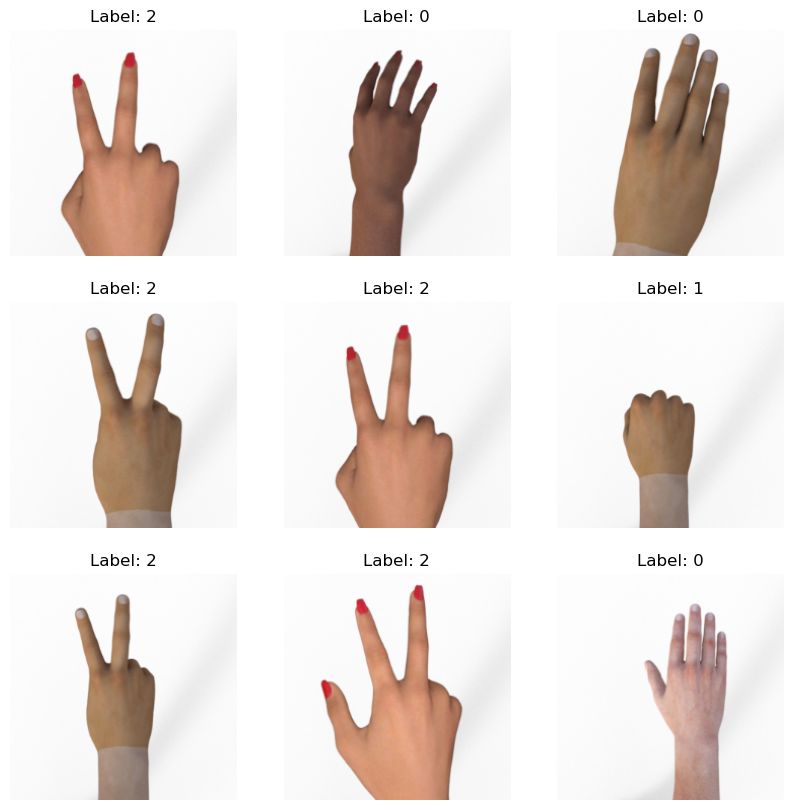

In [16]:
# Take one batch of images from training dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

# Data Augmentation (Optional but Recommended)

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [50]:
augmented_dir = r'F:\Project_Image\rps_augmented'
os.makedirs(augmented_dir, exist_ok=True)

total_augmented = 0

for cls in classes:
    cls_aug_dir = os.path.join(augmented_dir, cls)
    os.makedirs(cls_aug_dir, exist_ok=True)
    
    cls_path = os.path.join(train_dir, cls)
    files = os.listdir(cls_path)
    
    for i, f in enumerate(files):
        img_path = os.path.join(cls_path, f)
        img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        img_aug = data_augmentation(tf.expand_dims(img_array, 0))
        
        # Save augmented image
        tf.keras.utils.save_img(os.path.join(cls_aug_dir, f"{cls}_{i}.jpg"), img_aug[0].numpy())
        
        total_augmented += 1

print(f"Total augmented images created: {total_augmented}")

# Optional: count images per class
for cls in classes:
    cls_count = len(os.listdir(os.path.join(augmented_dir, cls)))
    print(f"Class '{cls}' augmented images: {cls_count}")

Total augmented images created: 368
Class 'rock' augmented images: 122
Class 'paper' augmented images: 122
Class 'scissors' augmented images: 124


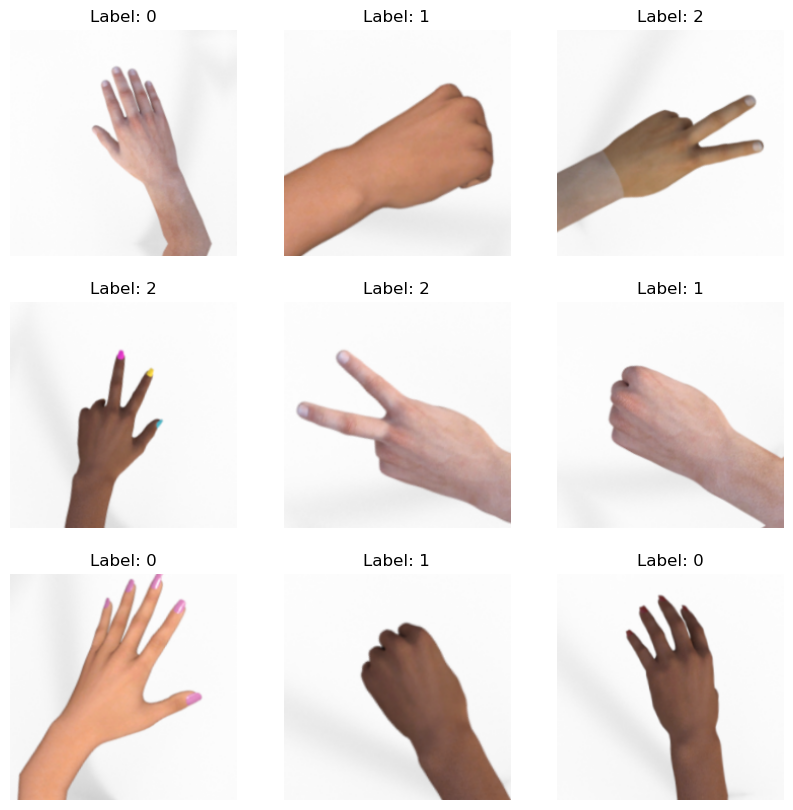

In [51]:
# Take one batch of images from training dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # Apply augmentation
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

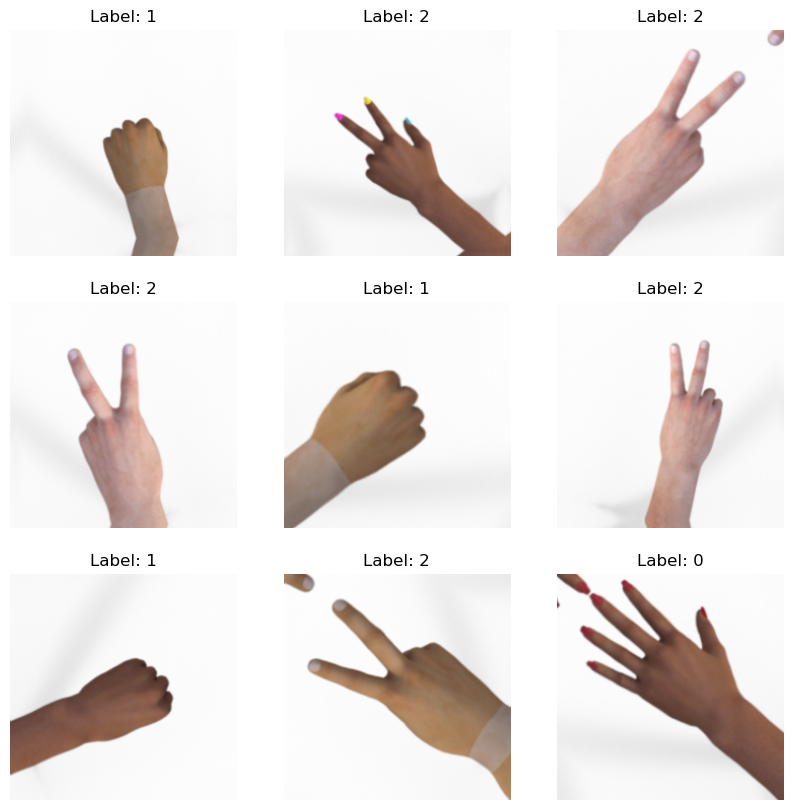

In [52]:
# Take one batch of images from training dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # Apply augmentation
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

# Load InceptionV3 Base Model

In [53]:
base_model = InceptionV3(
    weights=None,  # We will load custom weights
    include_top=False,  # We will add our own classification layers
    input_shape=(224, 224, 3)
)

# Load your weights
base_model.load_weights('F:\\Project_Image\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze base model layers
base_model.trainable = False


# Build Your Model

In [54]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                # Apply augmentation
x = preprocess_input(x)                      # Preprocess for InceptionV3
x = base_model(x, training=False)            # Pass through base model
x = layers.GlobalAveragePooling2D()(x)      # Pooling
x = layers.Dropout(0.5)(x)                  # Dropout for regularization
outputs = layers.Dense(3, activation='softmax')(x)  # 3 classes: rock, paper, scissors

model = models.Model(inputs, outputs)


# Compile the Model

In [55]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

# Callbacks for Training

In [56]:
# EarlyStopping callback to stop if validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Custom callback to stop at desired validation accuracy
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.95):  # Set target accuracy (95%)
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target:
            print(f"\nReached {self.target*100}% validation accuracy. Stopping training!")
            self.model.stop_training = True

# Instantiate the callback
stop_callback = StopAtAccuracy(target=0.95)

# ModelCheckpoint to save the best model in native Keras format (.keras)
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


# Train the Model with Callbacks

In [57]:
# Train the model with all callbacks together
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # Maximum number of epochs
    callbacks=[checkpoint, early_stop, stop_callback]  # Include all callbacks
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.3481 - loss: 1.7307
Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3481 - loss: 1.7254 - val_accuracy: 0.2222 - val_loss: 1.3910
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.2848 - loss: 1.5210
Epoch 2: val_accuracy improved from 0.22222 to 0.29630, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2853 - loss: 1.5185 - val_accuracy: 0.2963 - val_loss: 1.3278
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3682 - loss: 1.4042 
Epoch 3: val_accuracy improved from 0.29630 to 0.37037, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3681 - loss: 1.3986 - val_accuracy: 0.3704 - val_loss: 1.2487
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4223 - loss: 1.2184 
Epoch 4: val_accuracy improved from 0.37037 to 0.41

# Analyzing Training and Validation Results from Model History (Before Fine Tunning)

In [59]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [60]:
# Final training and validation accuracy
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])

# Final training and validation loss
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])


Final Training Accuracy: 0.782608687877655
Final Validation Accuracy: 0.7222222089767456
Final Training Loss: 0.5134384036064148
Final Validation Loss: 0.5584453344345093


In [61]:
for i, (train_acc, val_acc, train_loss, val_loss) in enumerate(zip(
    history.history['accuracy'],
    history.history['val_accuracy'],
    history.history['loss'],
    history.history['val_loss']
)):
    print(f"Epoch {i+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")


Epoch 1: Train Acc=0.3478, Val Acc=0.2222, Train Loss=1.6627, Val Loss=1.3910
Epoch 2: Train Acc=0.2908, Val Acc=0.2963, Train Loss=1.4881, Val Loss=1.3278
Epoch 3: Train Acc=0.3668, Val Acc=0.3704, Train Loss=1.3309, Val Loss=1.2487
Epoch 4: Train Acc=0.4212, Val Acc=0.4198, Train Loss=1.2107, Val Loss=1.1644
Epoch 5: Train Acc=0.4946, Val Acc=0.4691, Train Loss=1.0599, Val Loss=1.0868
Epoch 6: Train Acc=0.5109, Val Acc=0.4877, Train Loss=1.0851, Val Loss=1.0196
Epoch 7: Train Acc=0.5272, Val Acc=0.4938, Train Loss=0.9869, Val Loss=0.9654
Epoch 8: Train Acc=0.6114, Val Acc=0.5309, Train Loss=0.8693, Val Loss=0.9064
Epoch 9: Train Acc=0.6386, Val Acc=0.5309, Train Loss=0.8737, Val Loss=0.8678
Epoch 10: Train Acc=0.6304, Val Acc=0.5185, Train Loss=0.8035, Val Loss=0.8386
Epoch 11: Train Acc=0.6332, Val Acc=0.6049, Train Loss=0.7956, Val Loss=0.7684
Epoch 12: Train Acc=0.6495, Val Acc=0.6296, Train Loss=0.7715, Val Loss=0.7310
Epoch 13: Train Acc=0.6793, Val Acc=0.6420, Train Loss=0.7124

In [62]:
import pandas as pd

df = pd.DataFrame(history.history)
df.index += 1  # Start epoch count at 1
print(df)


    accuracy      loss  val_accuracy  val_loss
1   0.347826  1.662709      0.222222  1.391012
2   0.290761  1.488107      0.296296  1.327782
3   0.366848  1.330900      0.370370  1.248693
4   0.421196  1.210750      0.419753  1.164444
5   0.494565  1.059927      0.469136  1.086818
6   0.510870  1.085066      0.487654  1.019583
7   0.527174  0.986931      0.493827  0.965360
8   0.611413  0.869337      0.530864  0.906371
9   0.638587  0.873734      0.530864  0.867827
10  0.630435  0.803504      0.518519  0.838641
11  0.633152  0.795595      0.604938  0.768366
12  0.649457  0.771529      0.629630  0.731021
13  0.679348  0.712362      0.641975  0.704301
14  0.728261  0.618828      0.623457  0.693770
15  0.701087  0.666155      0.672840  0.658617
16  0.701087  0.681178      0.679012  0.640909
17  0.777174  0.580805      0.691358  0.618585
18  0.804348  0.522147      0.697531  0.597009
19  0.777174  0.559604      0.716049  0.588089
20  0.782609  0.513438      0.722222  0.558445


In [65]:
# df.to_csv('history.csv', index_label='Epoch')

# visually see how your model performed

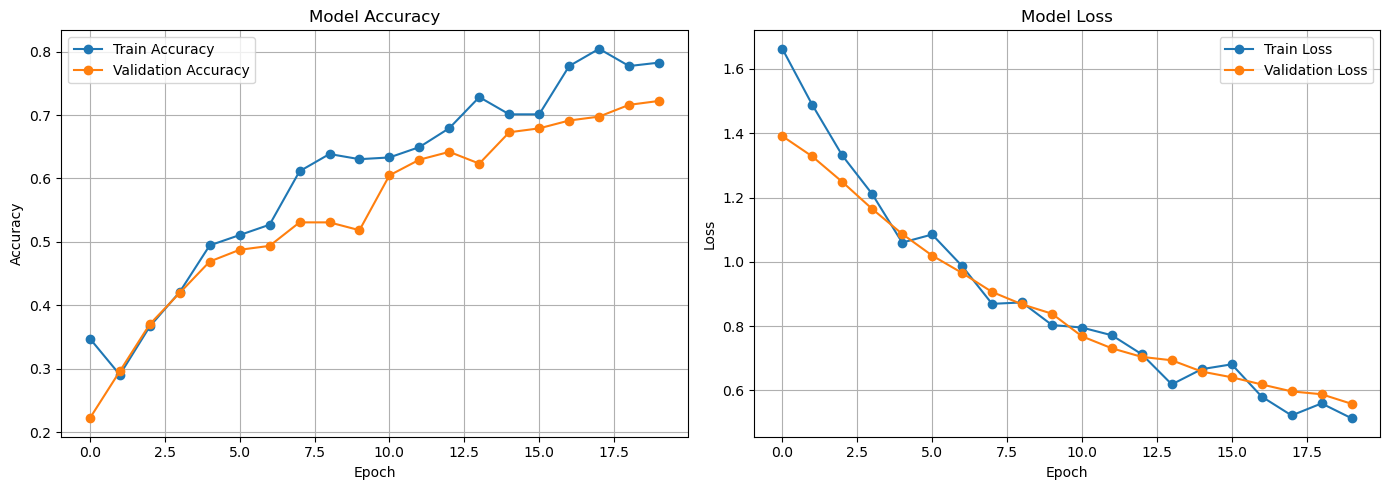

In [66]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 5))

# -----------------------
# Plot Accuracy on left
# -----------------------
plt.subplot(1, 2, 1)  # 1 row, 2 cols, 1st plot
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -----------------------
# Plot Loss on right
# -----------------------
plt.subplot(1, 2, 2)  # 1 row, 2 cols, 2nd plot
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show both plots side by side
plt.tight_layout()
plt.show()


In [71]:
loss, accuracy = best_model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 942ms/step - accuracy: 0.7035 - loss: 0.5754
Validation Loss: 0.5584
Validation Accuracy: 0.7222


# Fine-Tuning (Optional)

In [88]:
# Fine-Tuning 
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze first layers
    layer.trainable = False

# Recompile with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,  # Fine-tuning usually uses fewer epochs
    callbacks=[checkpoint, early_stop]  # You can include StopAtAccuracy if desired
)


Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7816 - loss: 0.5374   
Epoch 1: val_accuracy did not improve from 0.79630
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7808 - loss: 0.5403 - val_accuracy: 0.7963 - val_loss: 0.5652
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7900 - loss: 0.5450 
Epoch 2: val_accuracy did not improve from 0.79630
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7900 - loss: 0.5451 - val_accuracy: 0.7963 - val_loss: 0.5636
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7803 - loss: 0.5742 
Epoch 3: val_accuracy improved from 0.79630 to 0.80864, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7799 - loss: 0.5759 - val_accuracy: 0.8086 - val_loss: 0.5565
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7689 - loss: 0.5592 
Epoch 4: val_accuracy improved from 0.80864 to 0.82099, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/ste

# After Fine Tuning Visulization 

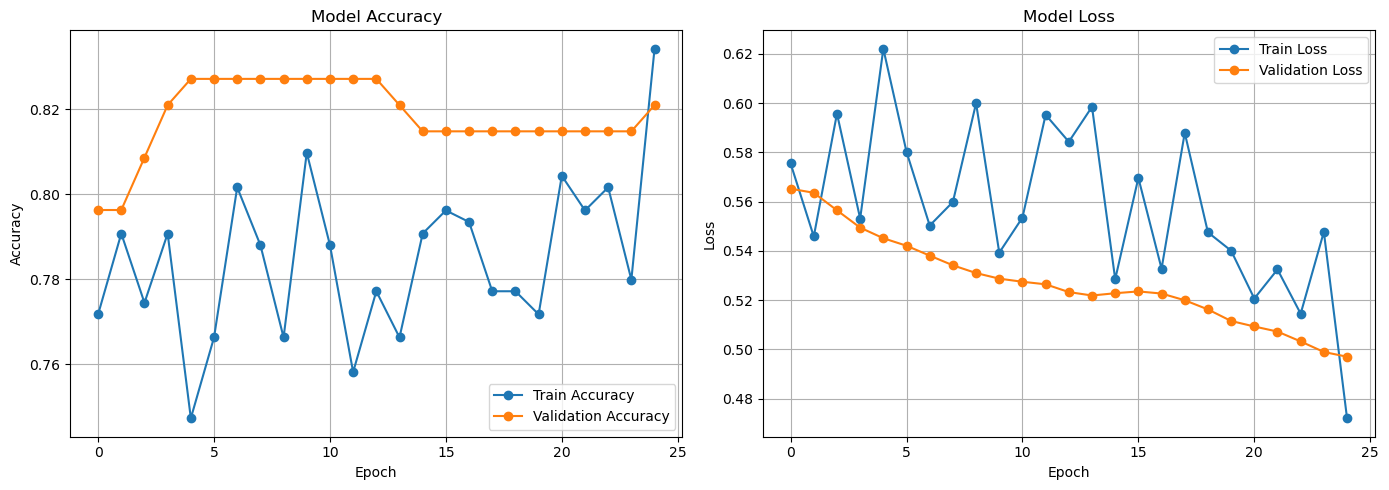

In [89]:
# Create a figure with 1 row and 2 columns
plt.figure(figsize=(14, 5))

# -----------------------
# Plot Accuracy on left
# -----------------------
plt.subplot(1, 2, 1)  # 1 row, 2 cols, 1st plot
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -----------------------
# Plot Loss on right
# -----------------------
plt.subplot(1, 2, 2)  # 1 row, 2 cols, 2nd plot
plt.plot(history_finetune.history['loss'], label='Train Loss', marker='o')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show both plots side by side
plt.tight_layout()
plt.show()


# Analyzing Training and Validation Results from Model History (After Fine Tunning)

In [90]:
history_finetune.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [91]:
# Final training and validation accuracy after fine-tuning
print("Final Training Accuracy (Fine-Tuned):", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy (Fine-Tuned):", history_finetune.history['val_accuracy'][-1])

# Final training and validation loss after fine-tuning
print("Final Training Loss (Fine-Tuned):", history_finetune.history['loss'][-1])
print("Final Validation Loss (Fine-Tuned):", history_finetune.history['val_loss'][-1])


Final Training Accuracy (Fine-Tuned): 0.83423912525177
Final Validation Accuracy (Fine-Tuned): 0.8209876418113708
Final Training Loss (Fine-Tuned): 0.4720357358455658
Final Validation Loss (Fine-Tuned): 0.4970233142375946


In [92]:
for i, (train_acc, val_acc, train_loss, val_loss) in enumerate(zip(
    history_finetune.history['accuracy'],
    history_finetune.history['val_accuracy'],
    history_finetune.history['loss'],
    history_finetune.history['val_loss']
)):
    print(f"Epoch {i+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")


Epoch 1: Train Acc=0.7717, Val Acc=0.7963, Train Loss=0.5755, Val Loss=0.5652
Epoch 2: Train Acc=0.7908, Val Acc=0.7963, Train Loss=0.5458, Val Loss=0.5636
Epoch 3: Train Acc=0.7745, Val Acc=0.8086, Train Loss=0.5957, Val Loss=0.5565
Epoch 4: Train Acc=0.7908, Val Acc=0.8210, Train Loss=0.5531, Val Loss=0.5494
Epoch 5: Train Acc=0.7473, Val Acc=0.8272, Train Loss=0.6221, Val Loss=0.5451
Epoch 6: Train Acc=0.7663, Val Acc=0.8272, Train Loss=0.5802, Val Loss=0.5421
Epoch 7: Train Acc=0.8016, Val Acc=0.8272, Train Loss=0.5503, Val Loss=0.5381
Epoch 8: Train Acc=0.7880, Val Acc=0.8272, Train Loss=0.5599, Val Loss=0.5341
Epoch 9: Train Acc=0.7663, Val Acc=0.8272, Train Loss=0.6000, Val Loss=0.5310
Epoch 10: Train Acc=0.8098, Val Acc=0.8272, Train Loss=0.5393, Val Loss=0.5287
Epoch 11: Train Acc=0.7880, Val Acc=0.8272, Train Loss=0.5535, Val Loss=0.5275
Epoch 12: Train Acc=0.7582, Val Acc=0.8272, Train Loss=0.5953, Val Loss=0.5264
Epoch 13: Train Acc=0.7772, Val Acc=0.8272, Train Loss=0.5843

In [93]:
# Create a DataFrame from fine-tuning history
df_finetune = pd.DataFrame(history_finetune.history)
df_finetune.index += 1  # Start epoch count at 1
print(df_finetune)


    accuracy      loss  val_accuracy  val_loss
1   0.771739  0.575507      0.796296  0.565239
2   0.790761  0.545842      0.796296  0.563598
3   0.774457  0.595743      0.808642  0.556470
4   0.790761  0.553138      0.820988  0.549447
5   0.747283  0.622063      0.827160  0.545136
6   0.766304  0.580212      0.827160  0.542089
7   0.801630  0.550287      0.827160  0.538077
8   0.788043  0.559876      0.827160  0.534148
9   0.766304  0.599975      0.827160  0.530993
10  0.809783  0.539269      0.827160  0.528725
11  0.788043  0.553526      0.827160  0.527462
12  0.758152  0.595268      0.827160  0.526429
13  0.777174  0.584309      0.827160  0.523276
14  0.766304  0.598510      0.820988  0.521883
15  0.790761  0.528495      0.814815  0.522808
16  0.796196  0.569651      0.814815  0.523541
17  0.793478  0.532771      0.814815  0.522677
18  0.777174  0.587951      0.814815  0.519951
19  0.777174  0.547534      0.814815  0.516228
20  0.771739  0.540077      0.814815  0.511529
21  0.804348 

In [95]:
# df_finetune.to_csv('fine_tuning_history.csv', index_label='Epoch')

# Save model

In [96]:
# After training
model.save("final_model.keras")   # saves the entire model (architecture + weights + optimizer)

# ✅ Now your model is ready for predictions.

In [97]:
from tensorflow.keras.models import load_model

# Load the model that was saved with highest validation accuracy
best_model = load_model('final_model.keras')


In [98]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,821,227 (83.24 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 12,296 (48.04 KB)

In [99]:
loss, accuracy = best_model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 876ms/step - accuracy: 0.8188 - loss: 0.5057
Validation Loss: 0.4970
Validation Accuracy: 0.8210


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted classes: [1 1 1 1 0 2 2 1 0 0 1 1 1 0 2 0 1 1 1 0 1 1 2 2 0 2 1 0 0 0 0 1]
Actual labels: [1 1 1 1 0 2 2 1 0 2 1 2 2 0 2 0 1 1 2 0 1 1 2 2 0 2 2 0 0 0 0 2]


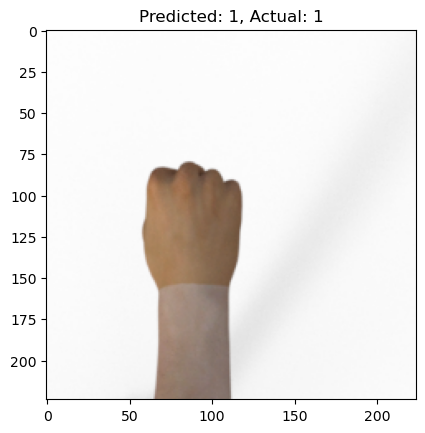

In [100]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Take one batch from validation dataset
for images, labels in val_dataset.take(1):
    preds = best_model.predict(images)
    preds_classes = tf.argmax(preds, axis=1)
    
    print("Predicted classes:", preds_classes.numpy())
    print("Actual labels:", labels.numpy())
    
    # Display the first image in the batch
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Predicted: {preds_classes[0].numpy()}, Actual: {labels[0].numpy()}")
    plt.show()


In [101]:
# Evaluate overall performance on the test dataset
loss, accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8971 - loss: 0.4436   
Test Loss: 0.4938
Test Accuracy: 0.8000


In [102]:
import tensorflow as tf
import numpy as np

all_preds = []
all_labels = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    preds_classes = tf.argmax(preds, axis=1)
    all_preds.extend(preds_classes.numpy())
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


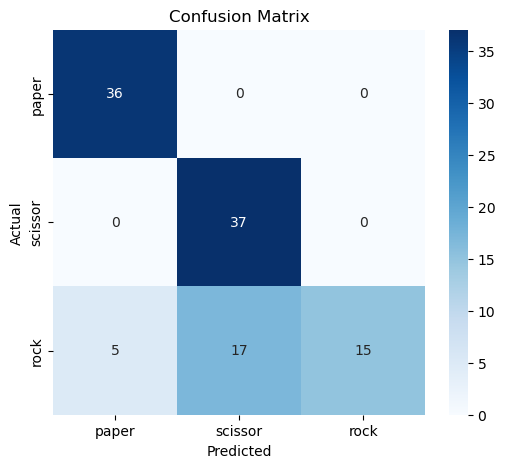

Classification Report:
               precision    recall  f1-score   support

       paper       0.88      1.00      0.94        36
     scissor       0.69      1.00      0.81        37
        rock       1.00      0.41      0.58        37

    accuracy                           0.80       110
   macro avg       0.85      0.80      0.78       110
weighted avg       0.85      0.80      0.77       110



In [103]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define your class names in order
class_labels = ['paper', 'scissor','rock']  # <-- change to match your dataset

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_labels)
print("Classification Report:\n", report)


In [104]:
from tensorflow.keras.models import load_model
import io
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load your trained model
model = load_model("final_model.keras")   # make sure this file exists in your directory

# Define your class labels
class_names = ['paper', 'rock', 'scissor']

# File upload widget
uploader = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False
)

button = widgets.Button(description="Predict")
output = widgets.Output()

def on_button_clicked(b):
    output.clear_output()
    
    if uploader.value:
        # Handle case where value is dict
        if isinstance(uploader.value, dict):
            file_name = list(uploader.value.keys())[0]
            content = uploader.value[file_name]['content']
        # Handle case where value is tuple
        elif isinstance(uploader.value, tuple):
            file_info = uploader.value[0]
            content = file_info['content']
            file_name = file_info['name']
        else:
            print("⚠️ Unsupported uploader.value type:", type(uploader.value))
            return
        
        # Load and preprocess image
        img = image.load_img(io.BytesIO(content), target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  

        with output:
            # Show uploaded image
            plt.imshow(img)
            plt.axis("off")
            plt.show()

            # Make prediction
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_label = class_names[predicted_class]

            print(f"Predicted class index: {predicted_class}")
            print(f"Predicted label: {predicted_label}")
    else:
        with output:
            print("⚠️ No file uploaded!")

button.on_click(on_button_clicked)

display(uploader, button, output)


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()